In [43]:
import numpy as np 
import pandas as pd

In [44]:
df=pd.read_csv("train.csv")

In [45]:
sequences=df['protein_sequence']
y_vals=df['tm']

In [46]:
from nltk import ngrams

In [47]:
char_seq = {'AA': 0}

max_seq = 0

import functools

# @functools.lru_cache(maxsize=None)
def get_char_index(c):
    
    if c in char_seq.keys():
        return char_seq[c]
    else:
        char_seq[c] = len(char_seq)
    
    return len(char_seq)
            
def to_seq(string):
    
    new_seq = [get_char_index("".join(t)) for t in ngrams(string, n=2)]
    
    return new_seq
        
    return counts


def create_features(df):
    
    df['seq'] = df['protein_sequence'].apply(to_seq)
    
#     df['counts'] = df['protein_sequence'].apply(get_counts)
        
    print(len(char_seq))

    return df

In [48]:
df = create_features(df)

400


In [49]:
import tensorflow
from tensorflow.keras.preprocessing import sequence
max_words = 1_000

X_train = sequence.pad_sequences(df['seq'].values, maxlen=max_words)

y_train = df['tm'].values

In [51]:
X_train=X_train.reshape(X_train.shape[0],X_train.shape[1],1)

In [52]:
class TransformerBlock(tensorflow.keras.layers.Layer):
    def __init__(self, embed_dim, feat_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = tensorflow.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tensorflow.keras.Sequential(
            [tensorflow.keras.layers.Dense(ff_dim, activation="gelu"), tensorflow.keras.layers.Dense(feat_dim),]
        )
        self.layernorm1 = tensorflow.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tensorflow.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tensorflow.keras.layers.Dropout(rate)
        self.dropout2 = tensorflow.keras.layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [53]:
feat_dim = X_train.shape[-1] + 32
embed_dim = 64  # Embedding size for attention
num_heads = 8  # Number of attention heads
ff_dim = 128  # Hidden layer size in feed forward network inside transformer
dropout_rate = 0.0
num_blocks = 12

In [54]:
def build_model():
    inputs = tensorflow.keras.layers.Input(shape=X_train.shape[-2:])
        
    # "EMBEDDING LAYER"
    x = tensorflow.keras.layers.Dense(feat_dim)(inputs)
    x = tensorflow.keras.layers.LayerNormalization(epsilon=1e-6)(x)
    
    # TRANSFORMER BLOCKS
    for k in range(num_blocks):
        x_old = x
        transformer_block = TransformerBlock(embed_dim, feat_dim, num_heads, ff_dim, dropout_rate)
        x = transformer_block(x)
        x = 0.7*x + 0.3*x_old # SKIP CONNECTION
    
    # REGRESSION HEAD
    x = tensorflow.keras.layers.Dense(128, activation="selu")(x)
    x = tensorflow.keras.layers.Dropout(dropout_rate)(x)
    outputs = tensorflow.keras.layers.Dense(1, activation="linear")(x)
    model = tensorflow.keras.Model(inputs=inputs, outputs=outputs)
        
    return model

Learning rate schedule: 0.0006 to 0.0006 to 1e-06


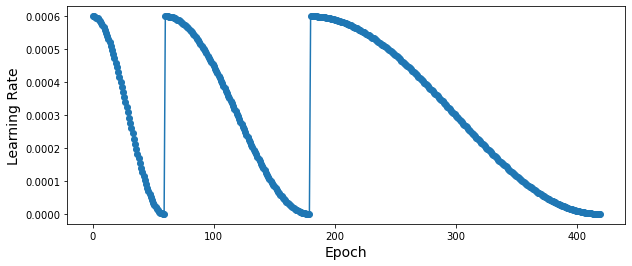

In [55]:
import tensorflow
import math 
import matplotlib.pyplot as plt

LR_START = 1e-6
LR_MAX = 6e-4
LR_MIN = 1e-6
LR_RAMPUP_EPOCHS = 0
LR_SUSTAIN_EPOCHS = 0
EPOCHS = 420
STEPS = [60,120,240]


def lrfn(epoch):
    if epoch<STEPS[0]:
        epoch2 = epoch
        EPOCHS2 = STEPS[0]
    elif epoch<STEPS[0]+STEPS[1]:
        epoch2 = epoch-STEPS[0]
        EPOCHS2 = STEPS[1]
    elif epoch<STEPS[0]+STEPS[1]+STEPS[2]:
        epoch2 = epoch-STEPS[0]-STEPS[1]
        EPOCHS2 = STEPS[2]
    
    if epoch2 < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch2 + LR_START
    elif epoch2 < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        decay_total_epochs = EPOCHS2 - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS - 1
        decay_epoch_index = epoch2 - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS
        phase = math.pi * decay_epoch_index / decay_total_epochs
        cosine_decay = 0.5 * (1 + math.cos(phase))
        lr = (LR_MAX - LR_MIN) * cosine_decay + LR_MIN
    return lr

rng = [i for i in range(EPOCHS)]
lr_y = [lrfn(x) for x in rng]
plt.figure(figsize=(10, 4))
plt.plot(rng, lr_y, '-o')
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}". \
          format(lr_y[0], max(lr_y), lr_y[-1]))
lr_callback = tensorflow.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)
plt.xlabel('Epoch',size=14)
plt.ylabel('Learning Rate',size=14)
plt.show()

In [56]:
model = build_model()
opt = tensorflow.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss="mse", sample_weight_mode="temporal",metrics=['RootMeanSquaredError'])

In [57]:
EPOCH = EPOCHS
BATCH_SIZE = 32
NUM_FOLDS = 11
VERBOSE = 1

In [58]:
X_train.shape

(31390, 1000, 1)

In [ ]:
history = model.fit(X_train, y_train, verbose=VERBOSE, epochs=EPOCH, batch_size=10)

Epoch 1/420
